In [106]:
import os
import glob
import warnings
import itertools
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.sparse import csr_matrix, issparse

import scanpy as sc
import scanpy.external as sce
import muon as mu
import anndata
from anndata import AnnData

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.pyplot import rc_context

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer
from sklearn.mixture import GaussianMixture

from upsetplot import UpSet, from_indicators
from paretoset import paretoset
from adjustText import adjust_text
from paretoset import paretoset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from paretoset import paretoset
from adjustText import adjust_text

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [96]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,dpi_save = 300,
    facecolor="white",
    frameon=True, fontsize = 8
)
sc.settings.figdir = "/new_figs/"
sns.set_theme(style="white")

In [97]:
def count_marker_combinations_heatmap(
    adata,
    gene_list,
    groupby,
    layer=None,
    threshold=0,
    normalize=False,
    show_heatmap=True,
    figsize=(10, 6),
    cmap="viridis",
    return_df=False,
    save_path=None,
    show_combinations=True,
    show_any_all=True,
    group_order=None,   # NEW PARAMETER
    swap_axes=False,    # NEW PARAMETER
):
    """
    Count number of positive cells for all individual genes and (optional) their combinations per group.

    Parameters
    ----------
    adata : AnnData
    gene_list : list of str
        List of gene names.
    groupby : str
        Column in adata.obs to group cells.
    layer : str or None
        Expression layer to use. If None, use adata.X.
    threshold : float
        Threshold above which a gene is considered expressed.
    normalize : bool
        If True, report percentages instead of counts.
    show_heatmap : bool
        If True, show heatmap of results.
    figsize : tuple
        Figure size for the heatmap.
    cmap : str
        Colormap for heatmap.
    return_df : bool
        If True, return the result DataFrame.
    save_path : str or None
        If given, save heatmap to this path.
    show_combinations : bool
        If True, compute pairwise (and larger) marker combinations.
    show_any_all : bool
        If True, include "Any+" and "All+" categories.
    group_order : list of str or None
        If given, order of groups in heatmap and results DataFrame. 
        Must be a subset/permutation of the groups in `adata.obs[groupby]`.
    swap_axes : bool
        If True, swap axes of the heatmap (groups on x-axis, markers on y-axis).

    Returns
    -------
    pd.DataFrame (optional)
        DataFrame with counts or percentages.
    """

    # Validate
    missing = [g for g in gene_list if g not in adata.var_names]
    if missing:
        raise ValueError(f"Missing genes in adata.var_names: {missing}")
    if groupby not in adata.obs.columns:
        raise ValueError(f"{groupby} is not a column in adata.obs")

    # Get expression matrix
    X = adata.X if layer is None else adata.layers[layer]
    if scipy.sparse.issparse(X):
        X = X.toarray()

    gene_idx = [adata.var_names.get_loc(g) for g in gene_list]
    gene_expr = X[:, gene_idx]
    binary_expr = (gene_expr > threshold).astype(int)

    group_labels = adata.obs[groupby].astype(str)
    unique_groups = group_labels.unique().tolist()

    # Apply custom order if provided
    if group_order is not None:
        missing_groups = [g for g in group_order if g not in unique_groups]
        if missing_groups:
            raise ValueError(f"Groups not found in '{groupby}': {missing_groups}")
        unique_groups = group_order
    else:
        unique_groups = sorted(unique_groups)

    group_mask_dict = {grp: (group_labels == grp).values for grp in unique_groups}

    # Prepare conditions
    conditions = []

    # Individual markers
    for i, g in enumerate(gene_list):
        mask = binary_expr[:, i]
        conditions.append((g, mask))

    # Any+ / All+
    if show_any_all:
        any_pos = (binary_expr.sum(axis=1) >= 1).astype(int)
        conditions.append(("Any+", any_pos))
        if len(gene_list) > 1:
            all_pos = (binary_expr.sum(axis=1) == len(gene_list)).astype(int)
            conditions.append(("All+", all_pos))

    # Combinations
    if show_combinations:
        for r in range(2, len(gene_list) + 1):
            for combo in itertools.combinations(range(len(gene_list)), r):
                genes = [gene_list[i] for i in combo]
                combo_name = " _ ".join(genes)
                combo_mask = np.any(binary_expr[:, combo], axis=1).astype(int)
                conditions.append((combo_name, combo_mask))

    # Build result df
    result = pd.DataFrame(index=unique_groups)
    for name, mask in conditions:
        values = []
        for group in unique_groups:
            gmask = group_mask_dict[group]
            count = mask[gmask].sum()
            total = gmask.sum()
            values.append((count / total * 100) if normalize else count)
        result[name] = values

    # Swap axes if requested
    if swap_axes:
        result = result.T

    # Plot
    if show_heatmap and not result.empty:
        plt.figure(figsize=figsize)
        sns.heatmap(
            result,
            annot=True,
            fmt=".1f" if normalize else ".0f",
            cmap=cmap
        )
        plt.title(
            f"Marker Positivity by {groupby}" + (" (%)" if normalize else " (count)")
        )
        plt.xlabel("Marker condition" if not swap_axes else groupby)
        plt.ylabel(groupby if not swap_axes else "Marker condition")
        plt.xticks(rotation=90, ha="right")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

    if return_df:
        return result


def add_gene_threshold_obs(adata, gene, layer, threshold):
    
    # Find gene index
    gene_idx = np.where(adata.var_names == gene)[0][0]
    
    # Extract expression for that gene in that layer
    expr = adata.layers[layer][:, gene_idx]
    
    # Convert sparse matrix if needed
    if not isinstance(expr, np.ndarray):
        expr = expr.toarray().ravel()
    
    # Create binary labels
    labels = np.where(expr > threshold, f"{gene}_pos", f"{gene}_neg")
    
    # Add to .obs
    adata.obs[f"{gene}_status"] = labels
    
    return adata

In [98]:

def create_ECF_df(adata,group):

    adata = adata[adata.obs["cluster_annotation"].isin(group)].copy()
    group_name = adata.obs["cluster_annotation"].iloc[0]
    
    #put the right layer 
    adata.X = adata.layers["scArch_transformed_log"].copy()
    print(f"Max raw counts: {np.max(adata.X)}")

    # Extract the counts matrix
    M = adata.X
    
    # Binarize the matrix
    binarizer = Binarizer(threshold=1.1)
    bin_M = binarizer.fit_transform(M)
    print(f"Max_after_bin: {np.max(bin_M)}")

    # Calculate ECF
    ECF = np.sum(bin_M, axis=0) / bin_M.shape[0] 
    ECF = np.array(ECF).flatten()

    #normalize data here
    adata.X = adata.layers["scArch_transformed"].copy()
    sc.pp.log1p(adata)
    M_norm = adata.X.copy()
    print(f"Max_after_normalization:{np.max(M_norm)}")
    
    # Calculate total expression sums
    exp_sums = np.sum(M_norm, axis=0)
    exp_sums = np.array(exp_sums).flatten()

    #non_zero _genes
    non_zero = np.count_nonzero(bin_M, axis = 0)


    
    # Calculate average expression for all
    avr_exp_all = exp_sums / M.shape[0]  # Average expression all
    avr_exp_NZ = exp_sums / non_zero  # Average expression among non zero cells
    


    # Get variable names
    var_names = adata.var_names
    
    # Multiply ECF by average expression
    ECF_times_avr_exp = ECF * avr_exp_all
    ECF_times_avr_exp_nz = ECF * avr_exp_NZ


    # Create a DataFrame with variable names and the computed values
    result_df = pd.DataFrame({
        'Gene': var_names,
        'ECF': ECF,
        'Average_Expression': avr_exp_all,
        'Average_Expression_non_zero': avr_exp_NZ,
        'ECF*Average_Expression': ECF_times_avr_exp,
        'ECF*Average_Expression_non_zero': ECF_times_avr_exp_nz

    })

    result_df['Average_Expression_non_zero'].fillna(0, inplace=True)

    
    result_df.columns = ['Gene'] + [f"{group_name}_{col}" for col in result_df.columns[1:]]


    sorted_df = result_df.sort_values(by=result_df.columns[4], ascending=False)

    return sorted_df   

def process_cluster(
    cluster, 
    joint_obj, 
    df_reference,
    group_name="HSC",
    n_top_adts=None,
    extra_genes=None,   # NEW PARAMETER
    save_path=None 
):
    """
    Process and visualize cluster data with ordered markers shown on both sides

    Args:
        cluster: Cluster identifier
        joint_obj: Joint object containing cluster data
        df_reference: Reference dataframe (previously df_HSC)
        group_name: Name of the reference group (default "HSC")
        n_top_adts: Number of top ADTs to show for each group (if None, show all)
        extra_genes: Gene name or list of gene names to force include in the plot
        save_path: Optional file path to save the plot (e.g., "output.png")
    """

    # Create ECF dataframe for the cluster
    df = create_ECF_df(joint_obj, group=[cluster])
    df = df[~df['Gene'].str.startswith('Isotype', na=False)]

    # Merge with reference dataframe
    df_merged = pd.merge(df, df_reference, on="Gene", how="inner")

    ref_ecf_col = f"{group_name}_ECF"
    if "HSC_ECF" in df_merged.columns and group_name != "HSC":
        df_merged = df_merged.rename(columns={"HSC_ECF": ref_ecf_col})

    def annotate_gene(row):
        if row[ref_ecf_col] > 0.5:
            return f"{group_name}_high"
        elif (row[f"{cluster}_ECF"] > 0.2) and (row[ref_ecf_col] < 0.5):
            return "cluster_optimum"
        else:
            return "not_relevant"

    expr_col = f"{cluster}_Average_Expression"
    df_merged["Annotation"] = df_merged.apply(annotate_gene, axis=1)

    cluster_high_df = df_merged[df_merged["Annotation"] == "cluster_optimum"].sort_values(
        f"{cluster}_ECF", ascending=True
    )
    ref_high_df = df_merged[df_merged["Annotation"] == f"{group_name}_high"].sort_values(
        ref_ecf_col, ascending=True
    )

    if n_top_adts is not None:
        cluster_high_df = cluster_high_df.tail(n_top_adts)
        ref_high_df = ref_high_df.tail(n_top_adts)

    # --- NEW PART: Add extra genes ---
    if extra_genes is not None:
        if isinstance(extra_genes, str):
            extra_genes = [extra_genes]
        extra_df = df_merged[df_merged["Gene"].isin(extra_genes)]
        # Make sure we don't duplicate genes already selected
        ordered_genes = pd.concat([ref_high_df, cluster_high_df, extra_df]).drop_duplicates("Gene")
    else:
        ordered_genes = pd.concat([ref_high_df, cluster_high_df])

    total_genes = len(ordered_genes)
    fig_height = max(6, total_genes * 0.3)
    fig, ax = plt.subplots(figsize=(15, fig_height))

    if expr_col in df_merged.columns:
        norm = mcolors.Normalize(
            vmin=ordered_genes[expr_col].min(),
            vmax=ordered_genes[expr_col].max()
        )

        bars_ref = ax.barh(
            ordered_genes["Gene"],
            -ordered_genes[ref_ecf_col],
            color=cm.Reds(norm(ordered_genes[expr_col])),
            label=group_name
        )
        bars_cluster = ax.barh(
            ordered_genes["Gene"],
            ordered_genes[f"{cluster}_ECF"],
            color=cm.viridis(norm(ordered_genes[expr_col])),
            label=cluster
        )

        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=-0.5, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=-0.8, color='red', linestyle='--', alpha=0.5)

        ax.set_xlabel("ECF Score", fontweight="bold")
        ax.set_ylabel("Gene", fontweight="bold")

        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticklabels(['1', '0.5', '0', '0.5', '1'])

        sm_ref = cm.ScalarMappable(cmap=cm.Reds, norm=norm)
        sm_cluster = cm.ScalarMappable(cmap=cm.viridis, norm=norm)

        fig.colorbar(sm_ref, ax=ax, location='left', pad=0.1).set_label('Expression Level', rotation=270, labelpad=15, fontweight="bold")
        fig.colorbar(sm_cluster, ax=ax, location='right', pad=0.1).set_label('Expression Level', rotation=270, labelpad=15, fontweight="bold")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

        print(f"Number of {cluster} high markers: {len(cluster_high_df)}")
        print(f"Number of {group_name} high markers: {len(ref_high_df)}")
        if extra_genes:
            print(f"Extra genes added: {extra_genes}")

        return ordered_genes, cluster_high_df, ref_high_df, df_merged

    else:
        print(f"Error: '{expr_col}' column not found in the dataframe.")
        print(f"Available columns: {df_merged.columns.tolist()}")
        return None, None, None


In [59]:
adata_prot = sc.read_h5ad("/scArch_prediction.h5ad")

#QC and filtering the ADT data

adata_prot.X = adata_prot.layers["raw_counts"].copy()
sc.pp.calculate_qc_metrics(adata_prot, inplace=True, percent_top=None)
def do_qc(df):
  
    return np.where((df["n_genes_by_counts"] > 14) & (df["total_counts"] > 200) &
                    (df["total_counts"] < 15000), "keep", "discard")

adata_prot.obs["QC_stat"] = do_qc(adata_prot.obs)
#sc.pl.scatter(AML_malig["adt"], y = "n_genes_by_counts", x = "total_counts",
#              color = "QC_stat", size = 10)
adata_prot = adata_prot[adata_prot.obs["QC_stat"].isin(["keep"])].copy()

############
AML_all = mu.read("/pAML_main.h5mu")
combined_metadata = pd.read_csv("/meta_annotation.csv", index_col = 0)
malig_meta = pd.read_csv("/all_samples_malignancy_scores.csv", index_col = 0)
AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]
AML_all["rna"].obs["malignancy_score"] = malig_meta["malignancy_score"]
AML_all["rna"].obs["malignancy_status"] = malig_meta["malignancy_status"]
AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]

AML_malig = adata_prot[(adata_prot.obs["malignancy_status"].isin(["malignant"])) & 
                  (~adata_prot.obs["mapped_healthy"].isin(["NK Cells", "B Cell", "T Cells"]))].copy()

cluster_meta = pd.read_csv("/clustering_malignant.csv",
                         index_col = 0)

AML_malig.obs["cluster"] = cluster_meta["cluster"].astype("str")
def rename_clusters(clusters):
    if clusters in ["0"]:
        return "Primitive_blastsI"
    if clusters in ["1"]:
        return "Cycling_cells"
    if clusters in ["2"]:
        return "Myeloid_mature_like"
    if clusters in ["3"]:
        return "AML12_specific"
    if clusters in ["4"]:
        return "GMP_like_state"
    if clusters in ["5"]:
        return "Stem_like_shared"
    if clusters in ["6"]:
        return "Primitive_blastsII"

AML_malig.obs["cluster_annotation"] = AML_malig.obs["cluster"].map(rename_clusters)
AML_malig.obs["cluster_annotation"] = AML_malig.obs["cluster_annotation"]

In [62]:
def plot_counts_threshold(adata, layer="X", bins=100, random_state=42):
    """
    Plot the distribution of counts in an AnnData object and estimate 
    background vs foreground using a 2-component Gaussian Mixture Model.
    
    Parameters:
        adata (AnnData): AnnData object containing the data.
        layer (str): Layer of adata to use (default "X").
        bins (int): Number of bins for the histogram (default 100).
        random_state (int): Random seed for reproducibility.
    
    Returns:
        float: Threshold between background and foreground counts.
    """
    # Extract counts
    if layer in adata.layers:
        data = adata.layers[layer]
    else:
        data = adata.X
    
    # Flatten to 1D
    counts = data.toarray().flatten() if hasattr(data, "toarray") else data.flatten()
    
    # Fit 2-component Gaussian mixture
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    counts_reshaped = counts.reshape(-1, 1)
    gmm.fit(counts_reshaped)
    
    # Extract means and covariances
    means = gmm.means_.flatten()
    covs = gmm.covariances_.flatten()
    
    # Identify background and foreground components
    bg_idx = np.argmin(means)
    fg_idx = np.argmax(means)
    
    # Compute threshold as midpoint between the two means
    threshold = (means[bg_idx] + means[fg_idx]) / 2
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=bins, color='gray', alpha=0.7, density=True, label='Counts')
    
    # Plot Gaussian curves
    x = np.linspace(counts.min(), counts.max(), 1000)
    bg_curve = (1 / np.sqrt(2 * np.pi * covs[bg_idx])) * np.exp(-(x - means[bg_idx])**2 / (2 * covs[bg_idx]))
    fg_curve = (1 / np.sqrt(2 * np.pi * covs[fg_idx])) * np.exp(-(x - means[fg_idx])**2 / (2 * covs[fg_idx]))
    plt.plot(x, bg_curve, color='blue', label='Background Gaussian')
    plt.plot(x, fg_curve, color='red', label='Foreground Gaussian')
    
    # Plot threshold
    plt.axvline(threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    
    plt.xlabel('Counts')
    plt.ylabel('Density')
    plt.title('Counts Distribution with 2-Component Gaussian Mixture')
    plt.legend()
    plt.show()
    
    return threshold


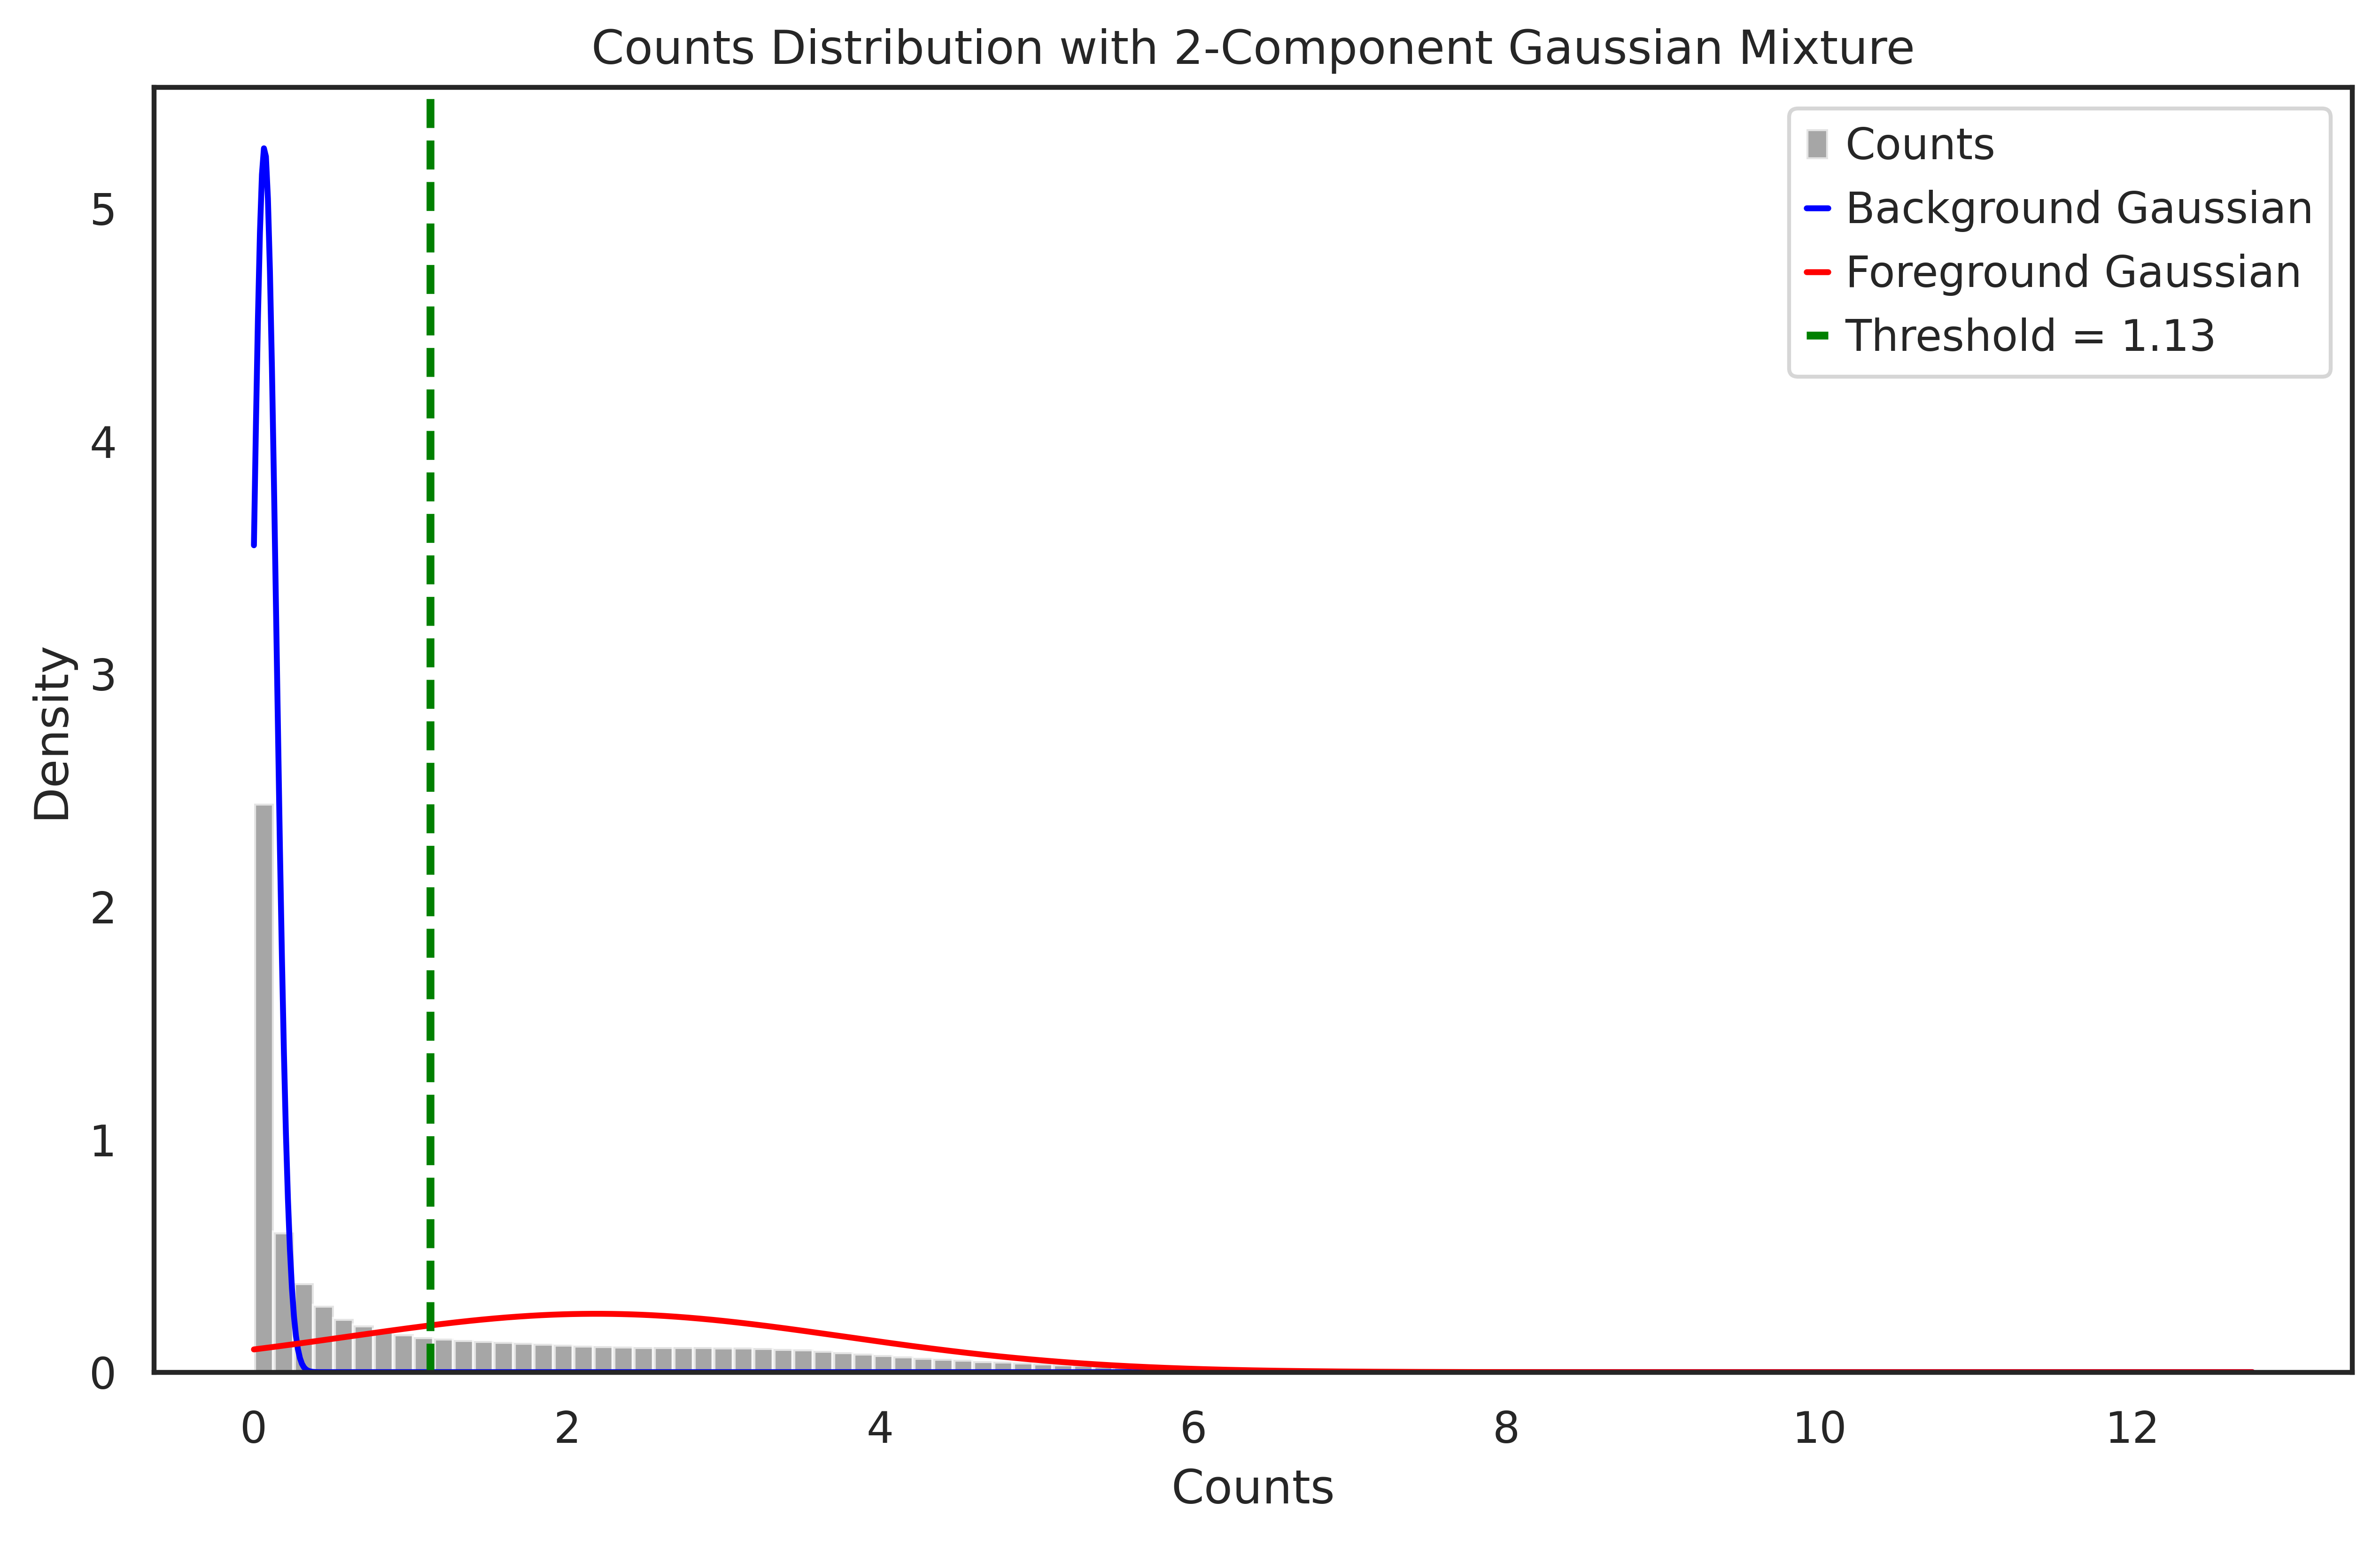

1.126754566827731

In [11]:
plot_counts_threshold(adata_prot,layer = "scArch_transformed_log" )

In [13]:
#Reading in Healthy data
healthy_adt = mu.read("/healthy_ref.h5mu")
joint_obj_healthy_HSCs = sc.concat([healthy_adt, AML_malig])

#taking HSCs from patients
#first post 
AML13 = mu.read("/AML13_Post.h5mu")
AML12 = mu.read("/AML12_Post.h5mu")

AML12_post_HSCs = AML12["rna"][(AML12["rna"].obs["ct_H_symph2"].isin(["HSC"])) & 
                        (AML12["rna"].obs["annotation"].isin(["Healthy_micor_env"]))].copy()

AML13_post_HSCs = AML13["rna"][(AML13["rna"].obs["ct_H_symph2"].isin(["HSC"])) & 
                        (AML13["rna"].obs["annotation"].isin(["Healthy_micor_env"]))].copy()
#then from Dx and Rel
Patient_HSCs = AML_all["rna"][(AML_all["rna"].obs["malignancy_status"].isin(["normal"])) & 
                  (AML_all["rna"].obs["state_major"].isin(["AML"])) &
                                    (AML_all["rna"].obs["mapped_healthy"].isin(["HSC"]))].copy()

#taking AVP high only 
all_HSCs = sc.concat([AML12_post_HSCs, AML13_post_HSCs, Patient_HSCs])


healthy_HSCs_patients =  adata_prot[adata_prot.obs_names.isin(all_HSCs.obs_names)].copy()
healthy_HSCs_patients.obs["cluster_annotation"] = "patient_HSCs"

joint_obj_patient_HSCs = sc.concat([healthy_HSCs_patients, AML_malig])

In [64]:
#Removing low quality patient for target discovery
joint_obj_healthy_HSCs = joint_obj_healthy_HSCs[~joint_obj_healthy_HSCs.obs["sample"].isin(["AML16_Rel"])].copy()
joint_obj_patient_HSCs = joint_obj_patient_HSCs[~joint_obj_patient_HSCs.obs["sample"].isin(["AML16_Rel"])].copy()

Max raw counts: 7.420525074005127
Max_after_bin: 1.0
Max_after_normalization:7.420525074005127
Max raw counts: 7.855827808380127
Max_after_bin: 1.0
Max_after_normalization:7.855827808380127
Plot saved to /home/sina.kanannejad/An_scriptnew/new_figs/Fig_4/HSC_LSC_ADT.pdf
Number of Stem_like_shared high markers: 10
Number of HSC high markers: 10
Extra genes added: ['IL3RA', 'CD33']


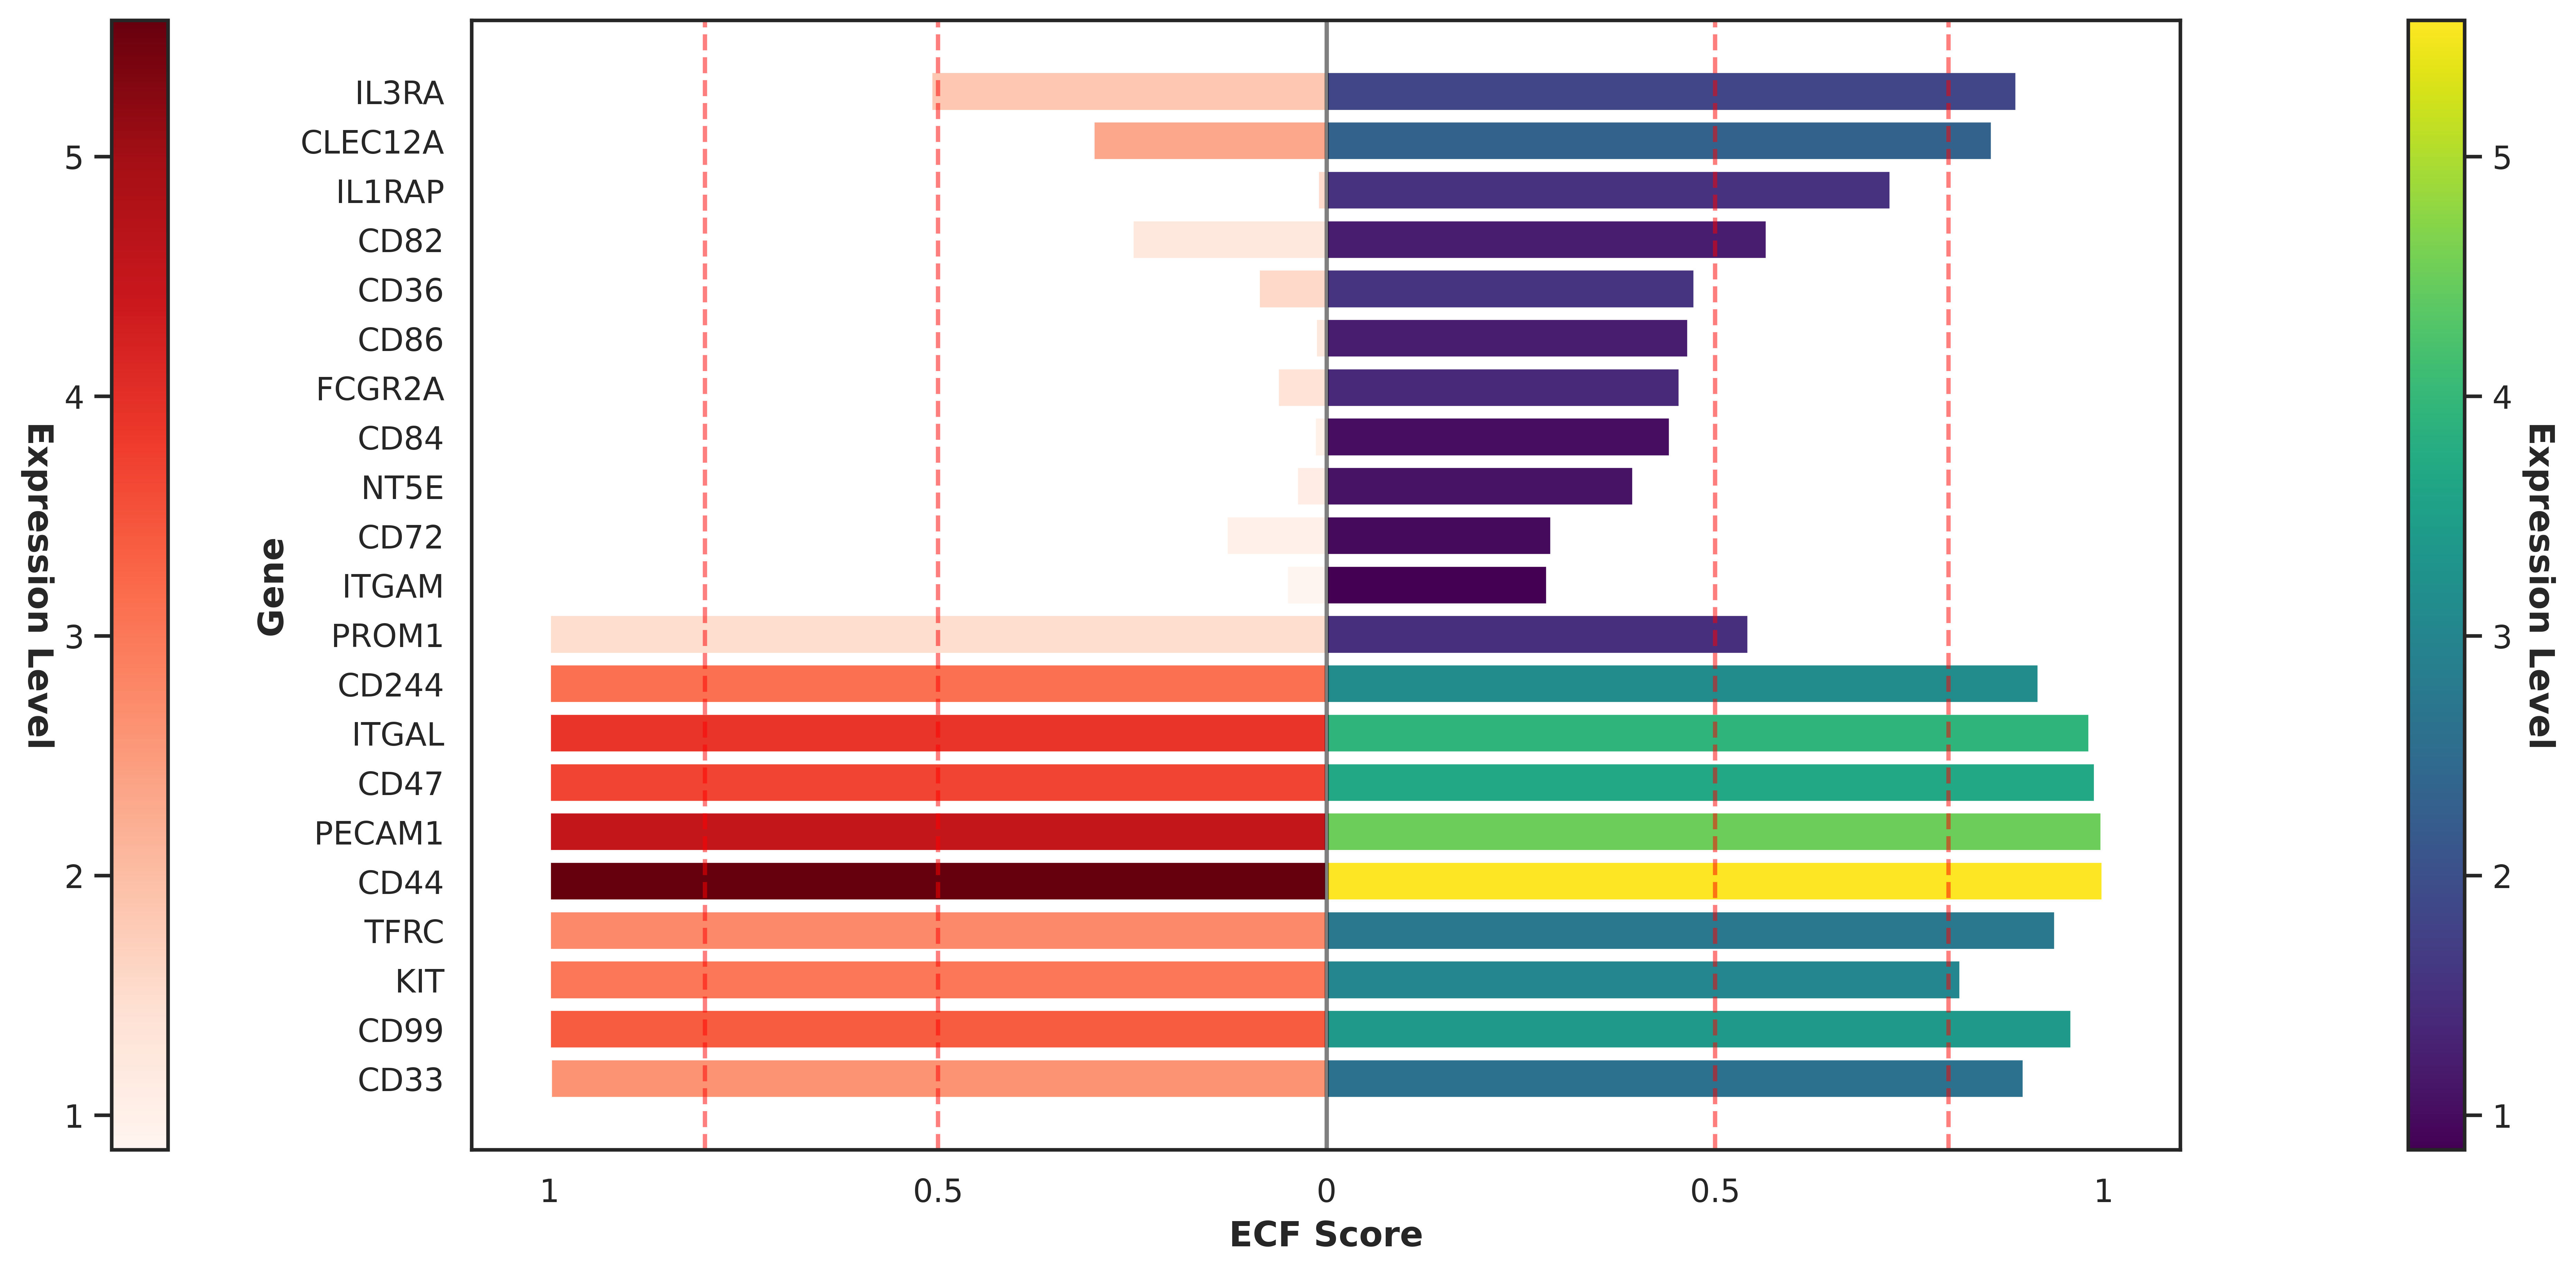

In [100]:
#Fig4_A
#Creating ECF_expression for healthy HSCs
df_HSC_healthy = create_ECF_df(joint_obj_healthy_HSCs, group= ["HSC"])
df_results, LSC_high_df_hHSC, HSC_df, df_all = process_cluster("Stem_like_shared",
                                                  joint_obj_healthy_HSCs, 
                                                    df_HSC_healthy, group_name="HSC", n_top_adts=10,extra_genes = ["IL3RA","CD33"],
                                                 save_path = "/HSC_LSC_ADT.pdf")

In [67]:
df_all["Annotation"].value_counts()

Annotation
not_relevant       26
HSC_high           24
cluster_optimum    19
Name: count, dtype: int64

In [68]:
w_list =  list(df_all["Gene"][df_all["Annotation"].isin(["cluster_optimum"])])
len(w_list)

19

In [102]:
def calculate_combination_ecf_or(
    adata,
    groupby,
    groups=None,
    whitelist=None,
    layer=None,
    max_comb=3
):
    """
    For each group, create a binary matrix for whitelist markers using a fixed threshold of 0,
    then compute ECF for all single, double, and triple marker combinations using OR logic.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    groupby : str
        Column in adata.obs to group by.
    groups : list or None
        List of group names to include. If None, use all unique values.
    whitelist : list
        List of marker names to include.
    layer : str or None
        Layer to use for expression values. If None, use adata.X.
    max_comb : int
        Maximum combination size (default 3 for singles, doubles, triples).

    Returns
    -------
    pd.DataFrame
        DataFrame with features (marker combinations) as index and columns as group ECFs.
    """
    import numpy as np
    import pandas as pd
    from itertools import combinations
    import scipy

    if whitelist is None:
        raise ValueError("You must provide a whitelist of marker names.")
    existing_markers = [m for m in whitelist if m in adata.var_names]
    missing_markers = [m for m in whitelist if m not in adata.var_names]
    if missing_markers:
        print(f"Warning: Markers not found: {missing_markers}")
    if not existing_markers:
        raise ValueError("No valid markers found in whitelist.")

    if groups is None:
        groups = adata.obs[groupby].unique().tolist()

    results = {}

    for group in groups:
        mask = adata.obs[groupby] == group
        subset = adata[mask].copy()
        subset = subset[:, existing_markers].copy()
        if layer is not None:
            X = subset.layers[layer]
        else:
            X = subset.X
        if scipy.sparse.issparse(X):
            X = X.toarray()

        # Binary matrix with threshold 0
        binary_matrix = (X > 1.1).astype(int)

        # OR logic for combinations
        group_ecf = {}
        for k in range(1, max_comb + 1):
            for combo in combinations(range(len(existing_markers)), k):
                combo_names = [existing_markers[i] for i in combo]
                feature_name = "_".join(combo_names)
                ecf = np.mean(np.any(binary_matrix[:, combo] == 1, axis=1))
                group_ecf[feature_name] = ecf

        results[f"{group}_ECF"] = group_ecf

    return pd.DataFrame(results)


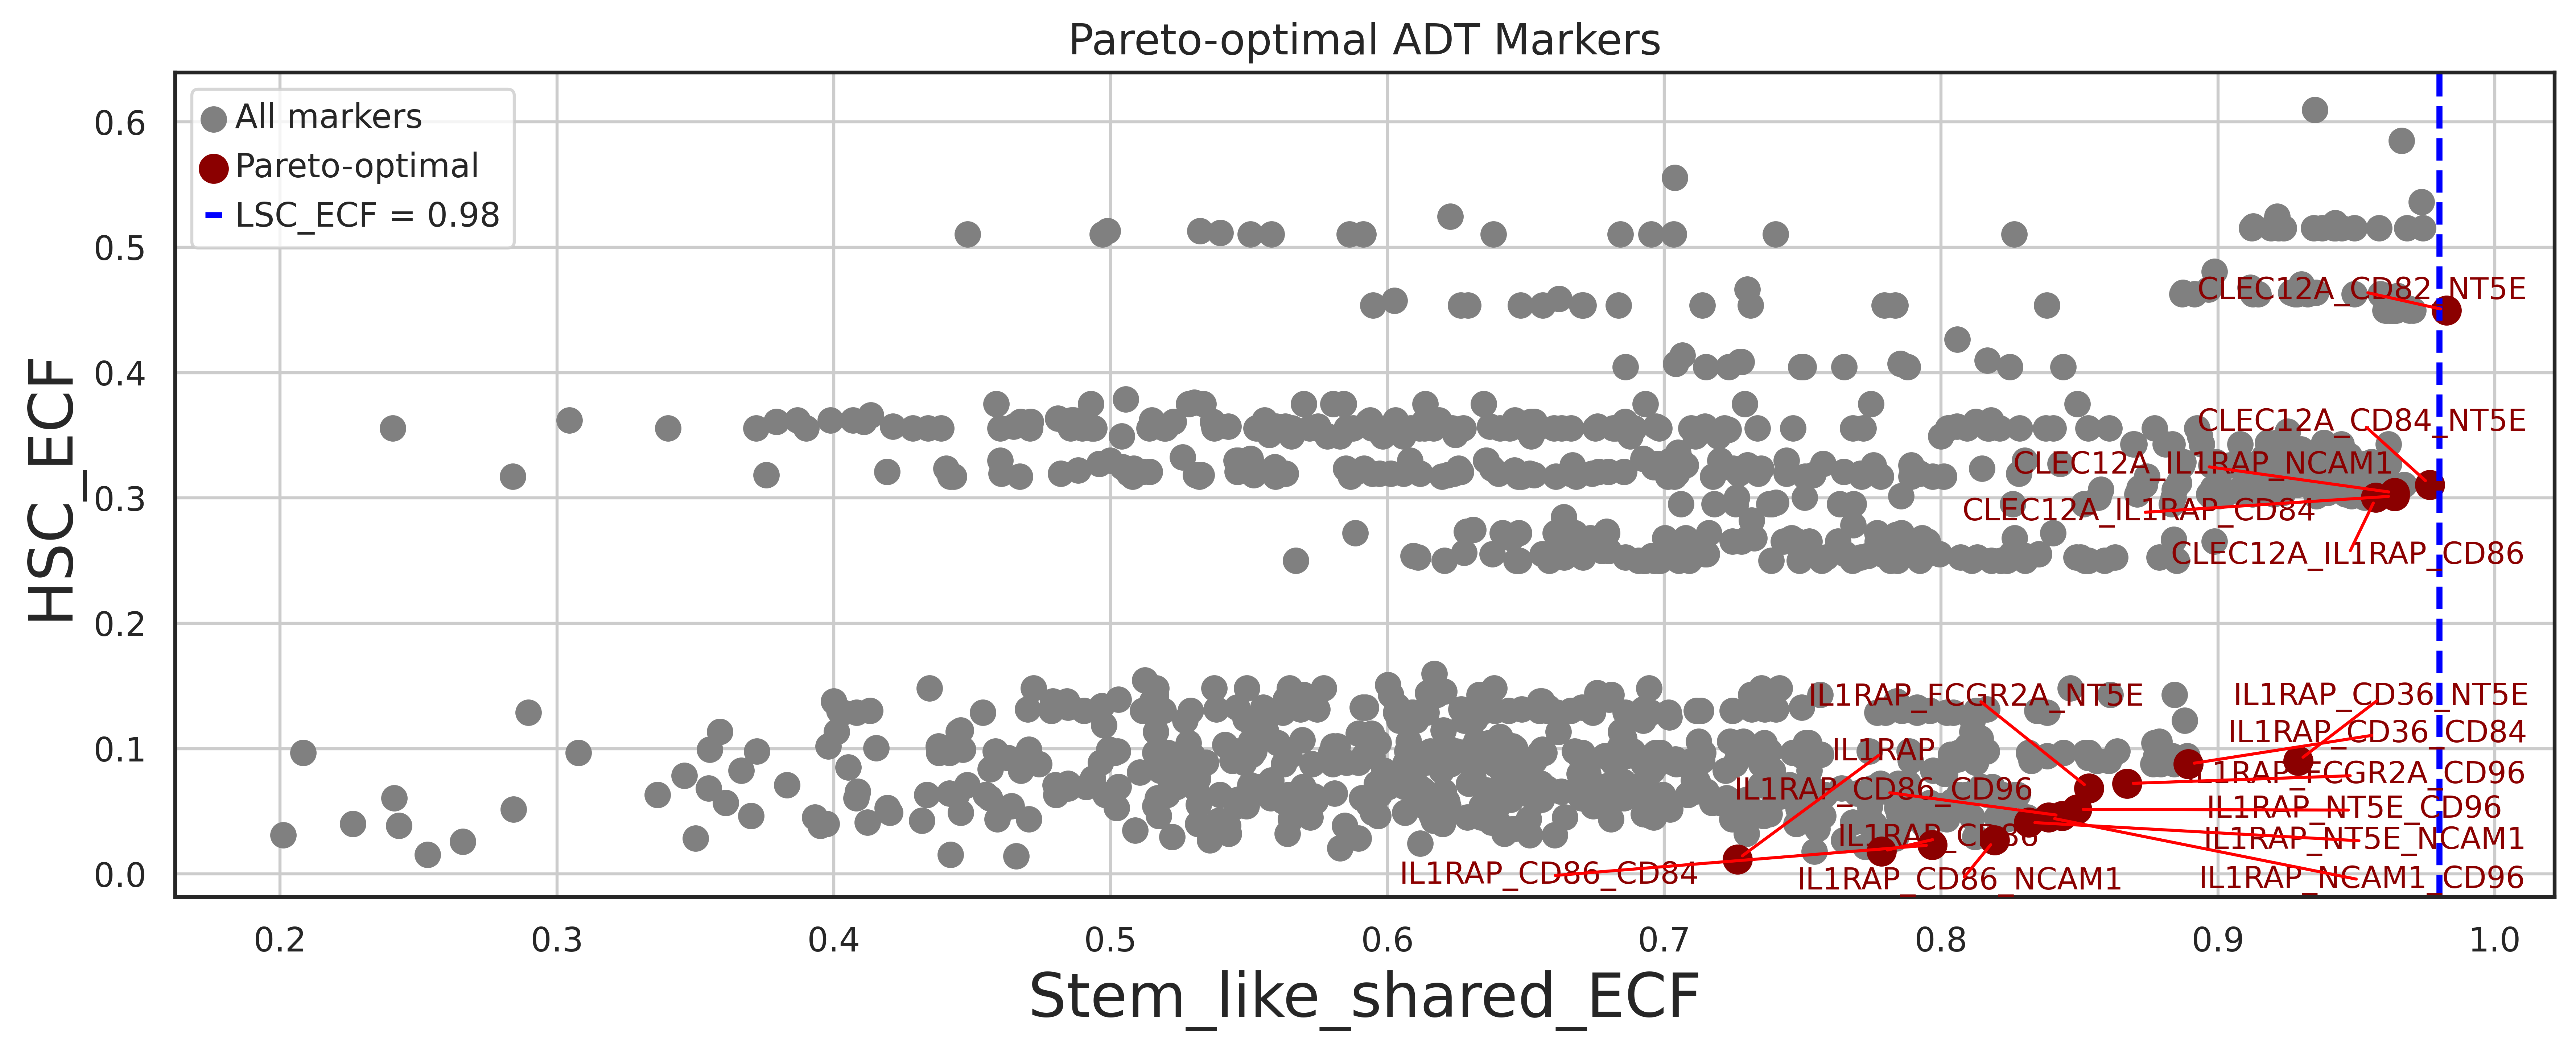

In [103]:
groups = ["Stem_like_shared","HSC"]

combined_plot = calculate_combination_ecf_or(
    adata=joint_obj_healthy_HSCs,
    groupby = "cluster_annotation",
    groups=groups,
    whitelist=w_list,
    layer="scArch_transformed_log",
    max_comb=3
)

# Identify Pareto-optimal points
mask = paretoset(combined_plot, sense=["max", "min"])
pareto_df = combined_plot[mask]

# Create scatter plot
plt.figure(figsize=(12, 5))
plt.scatter(combined_plot["Stem_like_shared_ECF"], combined_plot["HSC_ECF"], color="gray", s=60, label="All markers")
plt.scatter(pareto_df["Stem_like_shared_ECF"], pareto_df["HSC_ECF"], color="darkred", s=80, label="Pareto-optimal")
plt.axvline(x=0.98, color='blue', linestyle='--', linewidth=2, label='LSC_ECF = 0.98')  # Vertical line
#plt.axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='HSC_ECF = 0.5')   # Horizontal line

# Label Pareto points with repel
texts = []
for idx in pareto_df.index:
    x = pareto_df.loc[idx, "Stem_like_shared_ECF"]
    y = pareto_df.loc[idx, "HSC_ECF"]
    texts.append(plt.text(x, y, idx, fontsize=10,color = "darkred"))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'), expand_points=(1, 1), force_points=0.8)



# Plot styling
plt.xlabel("Stem_like_shared_ECF", fontsize=20)
plt.ylabel("HSC_ECF", fontsize=20)
plt.title("Pareto-optimal ADT Markers", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [71]:
len(pareto_df)

17

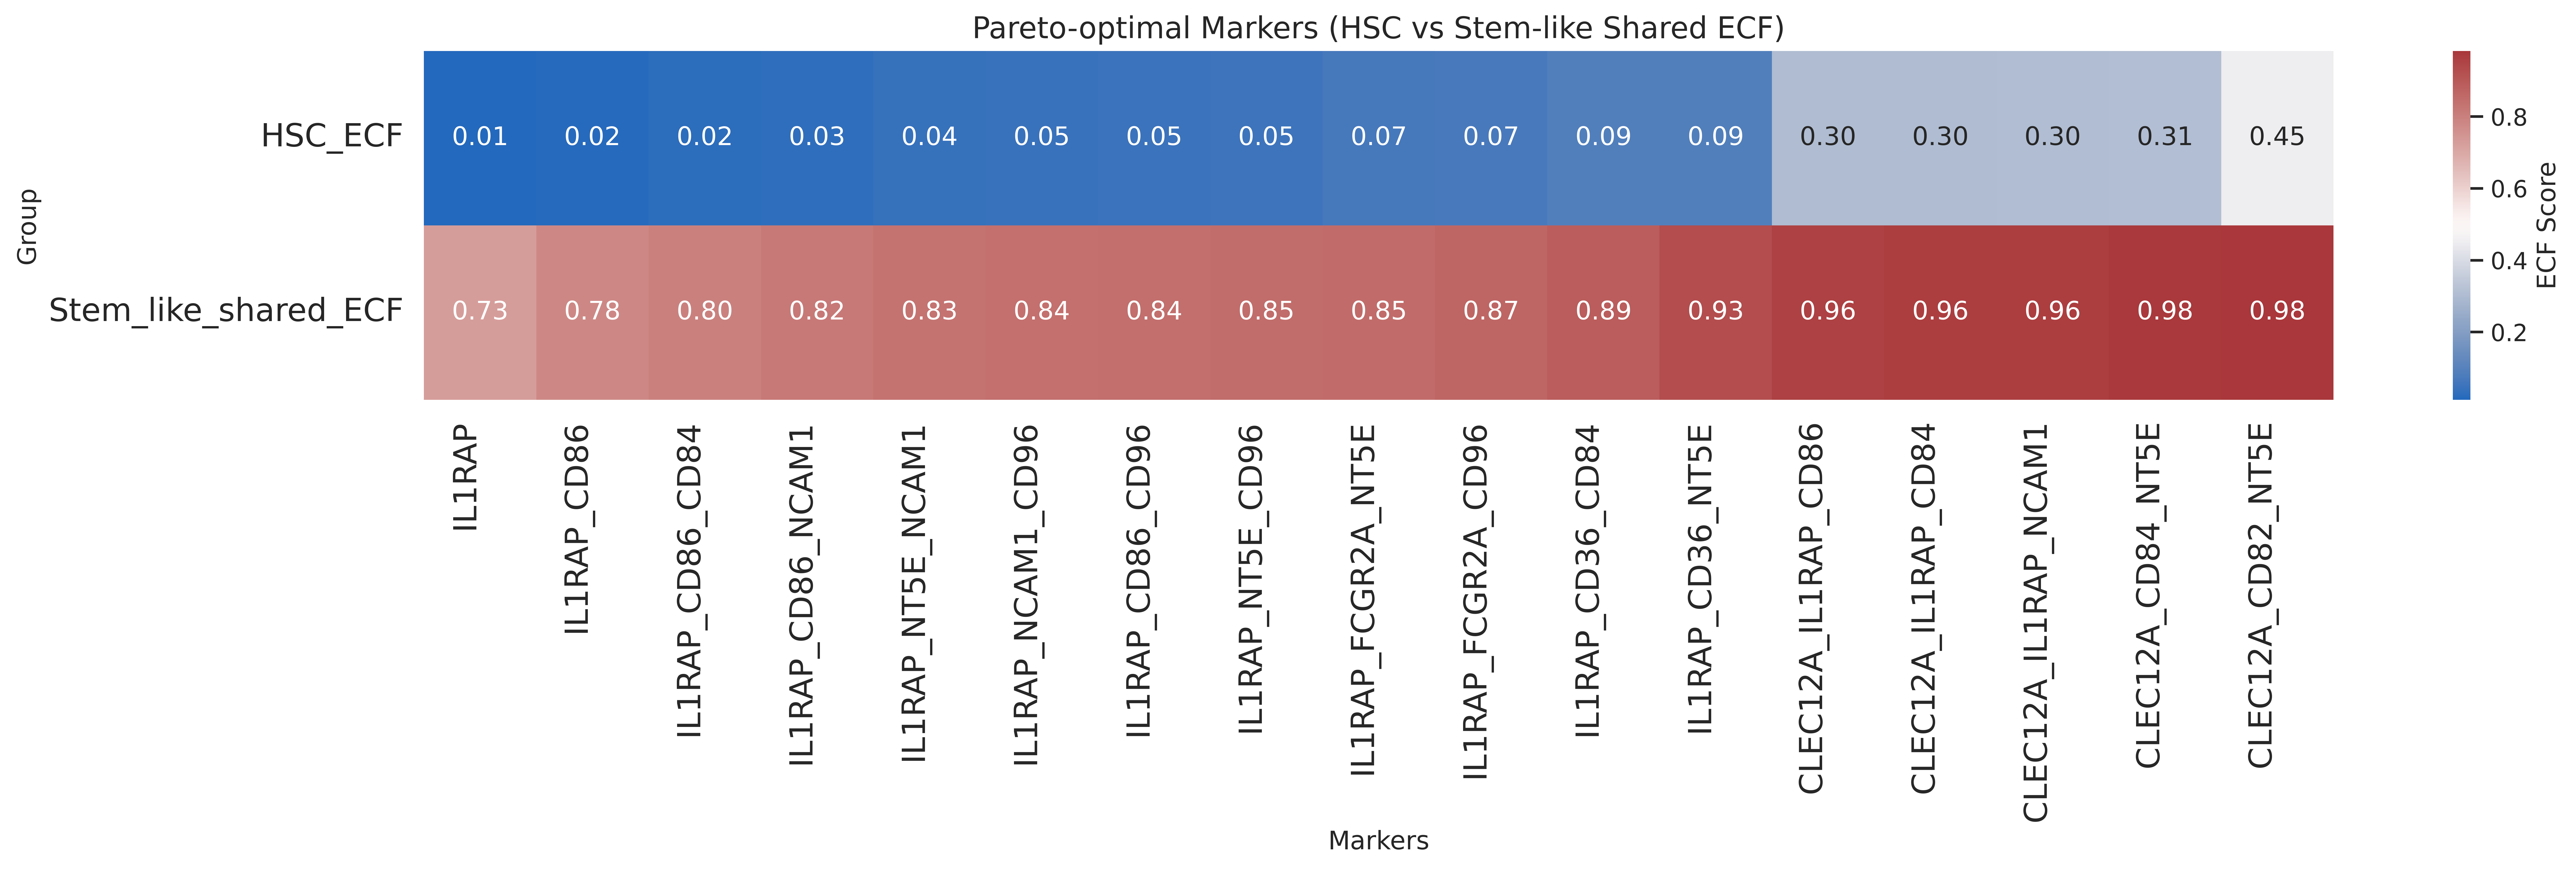

In [108]:
groups = ["Stem_like_shared","HSC"]

combined_plot = calculate_combination_ecf_or(
    adata=joint_obj_healthy_HSCs,
    groupby = "cluster_annotation",
    groups=groups,
    whitelist=w_list,
    layer="scArch_transformed_log",
    max_comb=3
)


# Identify Pareto-optimal points
mask = paretoset(combined_plot, sense=["max", "min"])
pareto_df = combined_plot[mask]

# Sort markers by Stem_like_shared_ECF
pareto_df = pareto_df.sort_values("Stem_like_shared_ECF", ascending=True)

# Create a matrix for heatmap: 2 rows (HSC_ECF and Stem_like_shared_ECF), columns = marker names
heatmap_data = pd.DataFrame({
    marker: [pareto_df.loc[marker, "HSC_ECF"], pareto_df.loc[marker, "Stem_like_shared_ECF"]]
    for marker in pareto_df.index
}, index=["HSC_ECF", "Stem_like_shared_ECF"])

# Plot heatmap
plt.figure(figsize=(20, 3))  # Adjust width based on number of markers
sns.heatmap(
    heatmap_data,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "ECF Score"}
)

# Styling
plt.title("Pareto-optimal Markers (HSC vs Stem-like Shared ECF)", fontsize=14)
plt.xlabel("Markers")
plt.ylabel("Group")
plt.xticks(ha="right", fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.savefig("/pareto_optimal_markers_hHSCs.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [109]:
combs_HSC = list(pareto_df.index)
combs_HSC

['IL1RAP',
 'IL1RAP_CD86',
 'IL1RAP_CD86_CD84',
 'IL1RAP_CD86_NCAM1',
 'IL1RAP_NT5E_NCAM1',
 'IL1RAP_NCAM1_CD96',
 'IL1RAP_CD86_CD96',
 'IL1RAP_NT5E_CD96',
 'IL1RAP_FCGR2A_NT5E',
 'IL1RAP_FCGR2A_CD96',
 'IL1RAP_CD36_CD84',
 'IL1RAP_CD36_NT5E',
 'CLEC12A_IL1RAP_CD86',
 'CLEC12A_IL1RAP_CD84',
 'CLEC12A_IL1RAP_NCAM1',
 'CLEC12A_CD84_NT5E',
 'CLEC12A_CD82_NT5E']

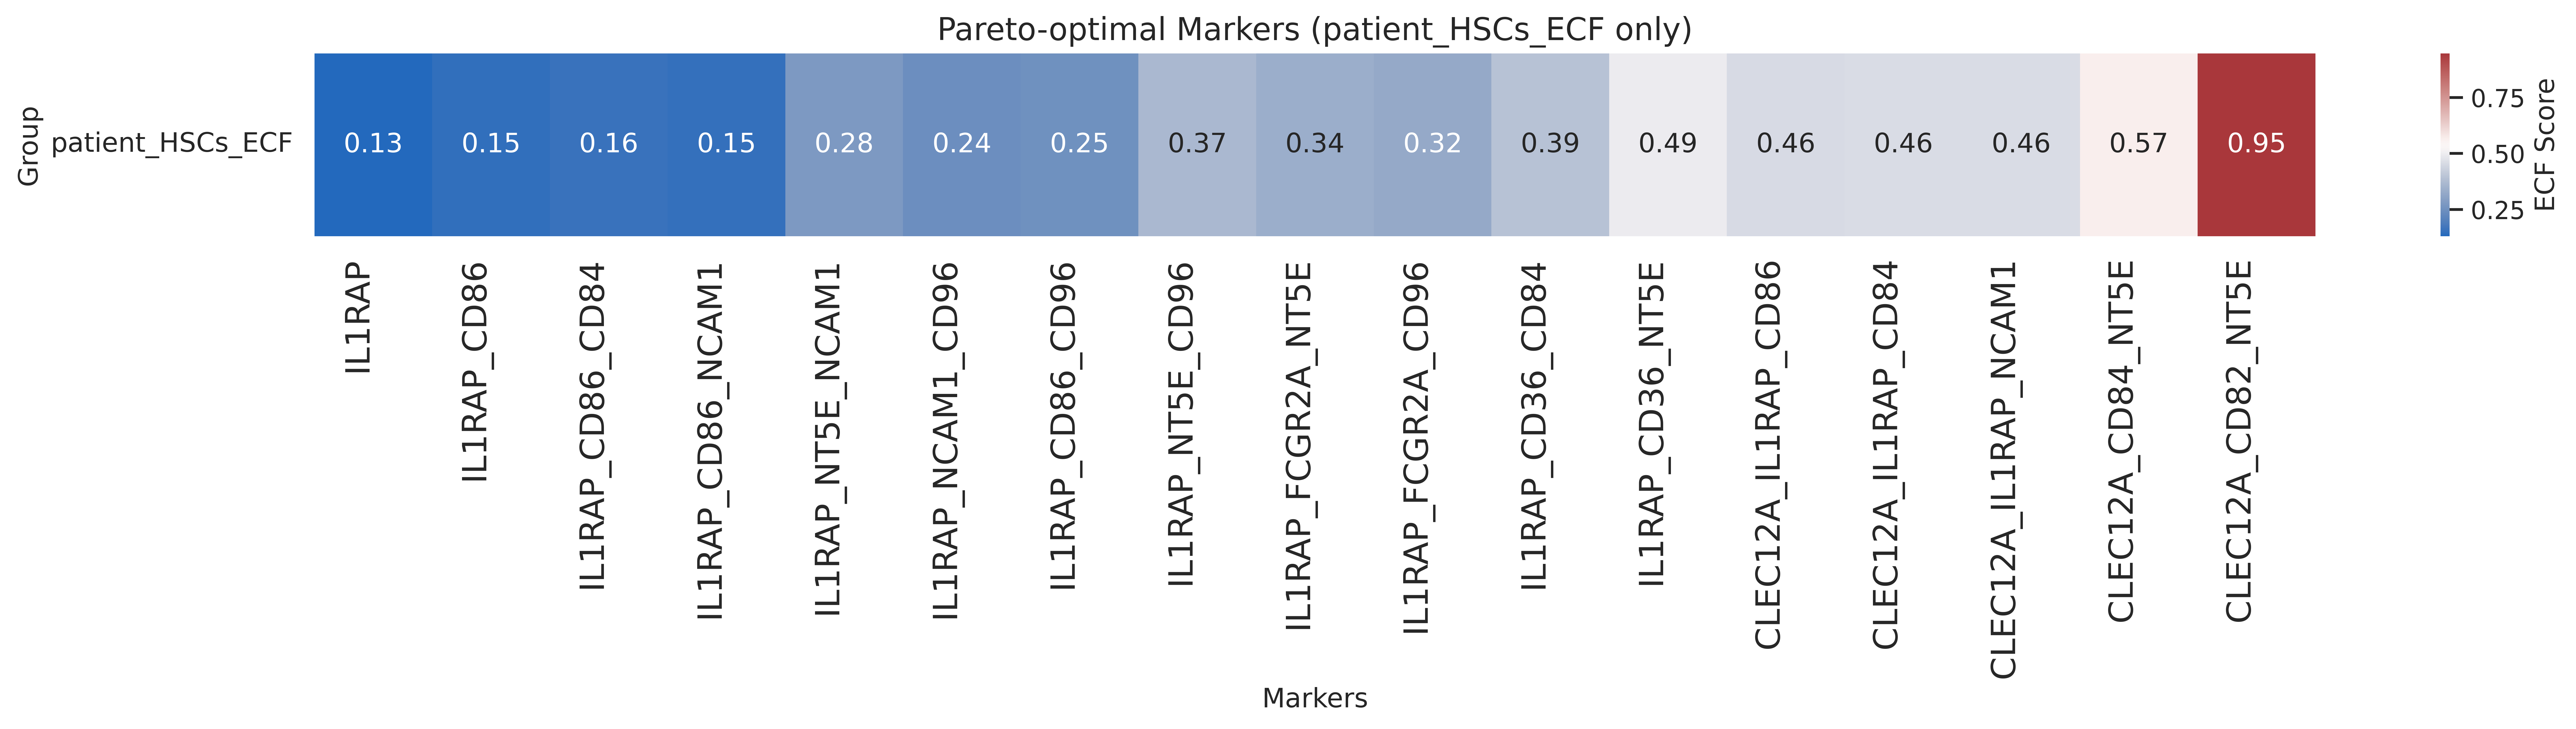

In [110]:
groups = ["Stem_like_shared","patient_HSCs"]

combined_plot = calculate_combination_ecf_or(
    adata=joint_obj_patient_HSCs,
    groupby="cluster_annotation",
    groups=groups,
    whitelist=w_list,
    layer="scArch_transformed_log",
    max_comb=3
)
combined_plot[0:10]

#keep the same as HSCs
pareto_df = combined_plot[combined_plot.index.isin(combs_HSC)]

# Identify Pareto-optimal points
#mask = paretoset(combined_plot, sense=["max", "min"])
#pareto_df = combined_plot[mask]

# Keep only those shared with combs_HSC
#pareto_df = pareto_df[pareto_df.index.isin(combs_HSC)]

# 🔑 Sort markers by Stem_like_shared_ECF
pareto_df = pareto_df.sort_values("Stem_like_shared_ECF", ascending=True)
pareto_df = pareto_df.T
# 🔑 Keep only the patient_HSCs_ECF row
heatmap_data_subset = pareto_df.loc[["patient_HSCs_ECF"], :]

# Plot heatmap
plt.figure(figsize=(20, 1.5))  # shorter height since it's 1 row
sns.heatmap(
    heatmap_data_subset,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "ECF Score"}
)

# Styling
plt.title("Pareto-optimal Markers (patient_HSCs_ECF only)", fontsize=14)
plt.xlabel("Markers")
plt.ylabel("Group")
plt.xticks(ha="right", fontsize=15)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Save
plt.savefig(
    "/pareto_optimal_markers_pHSCs_only.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()



In [111]:
def clear_annot (cluster_annotation):
    if cluster_annotation in ["HSC"]:
        return "HSC"
    if cluster_annotation in ["Stem_like_shared"]:
        return "Stem_like_shared"
    if cluster_annotation in ["CD14 Mono","ProMono"]:
        return "Monocytes"
    if cluster_annotation in ['MEP','Pro-Eryth', 'GMP', 'Early_GMP', 'LMPP']:
        return "HPCs"                         
                              
    else:
        return "Malignant_Blasts"   
    
joint_obj_healthy_HSCs.obs["new_cluster_annot"] = joint_obj_healthy_HSCs.obs["cluster_annotation"].map(clear_annot)
    

In [112]:
group_order = ["Monocytes","HPCs", "HSC", "Malignant_Blasts", "Stem_like_shared"]

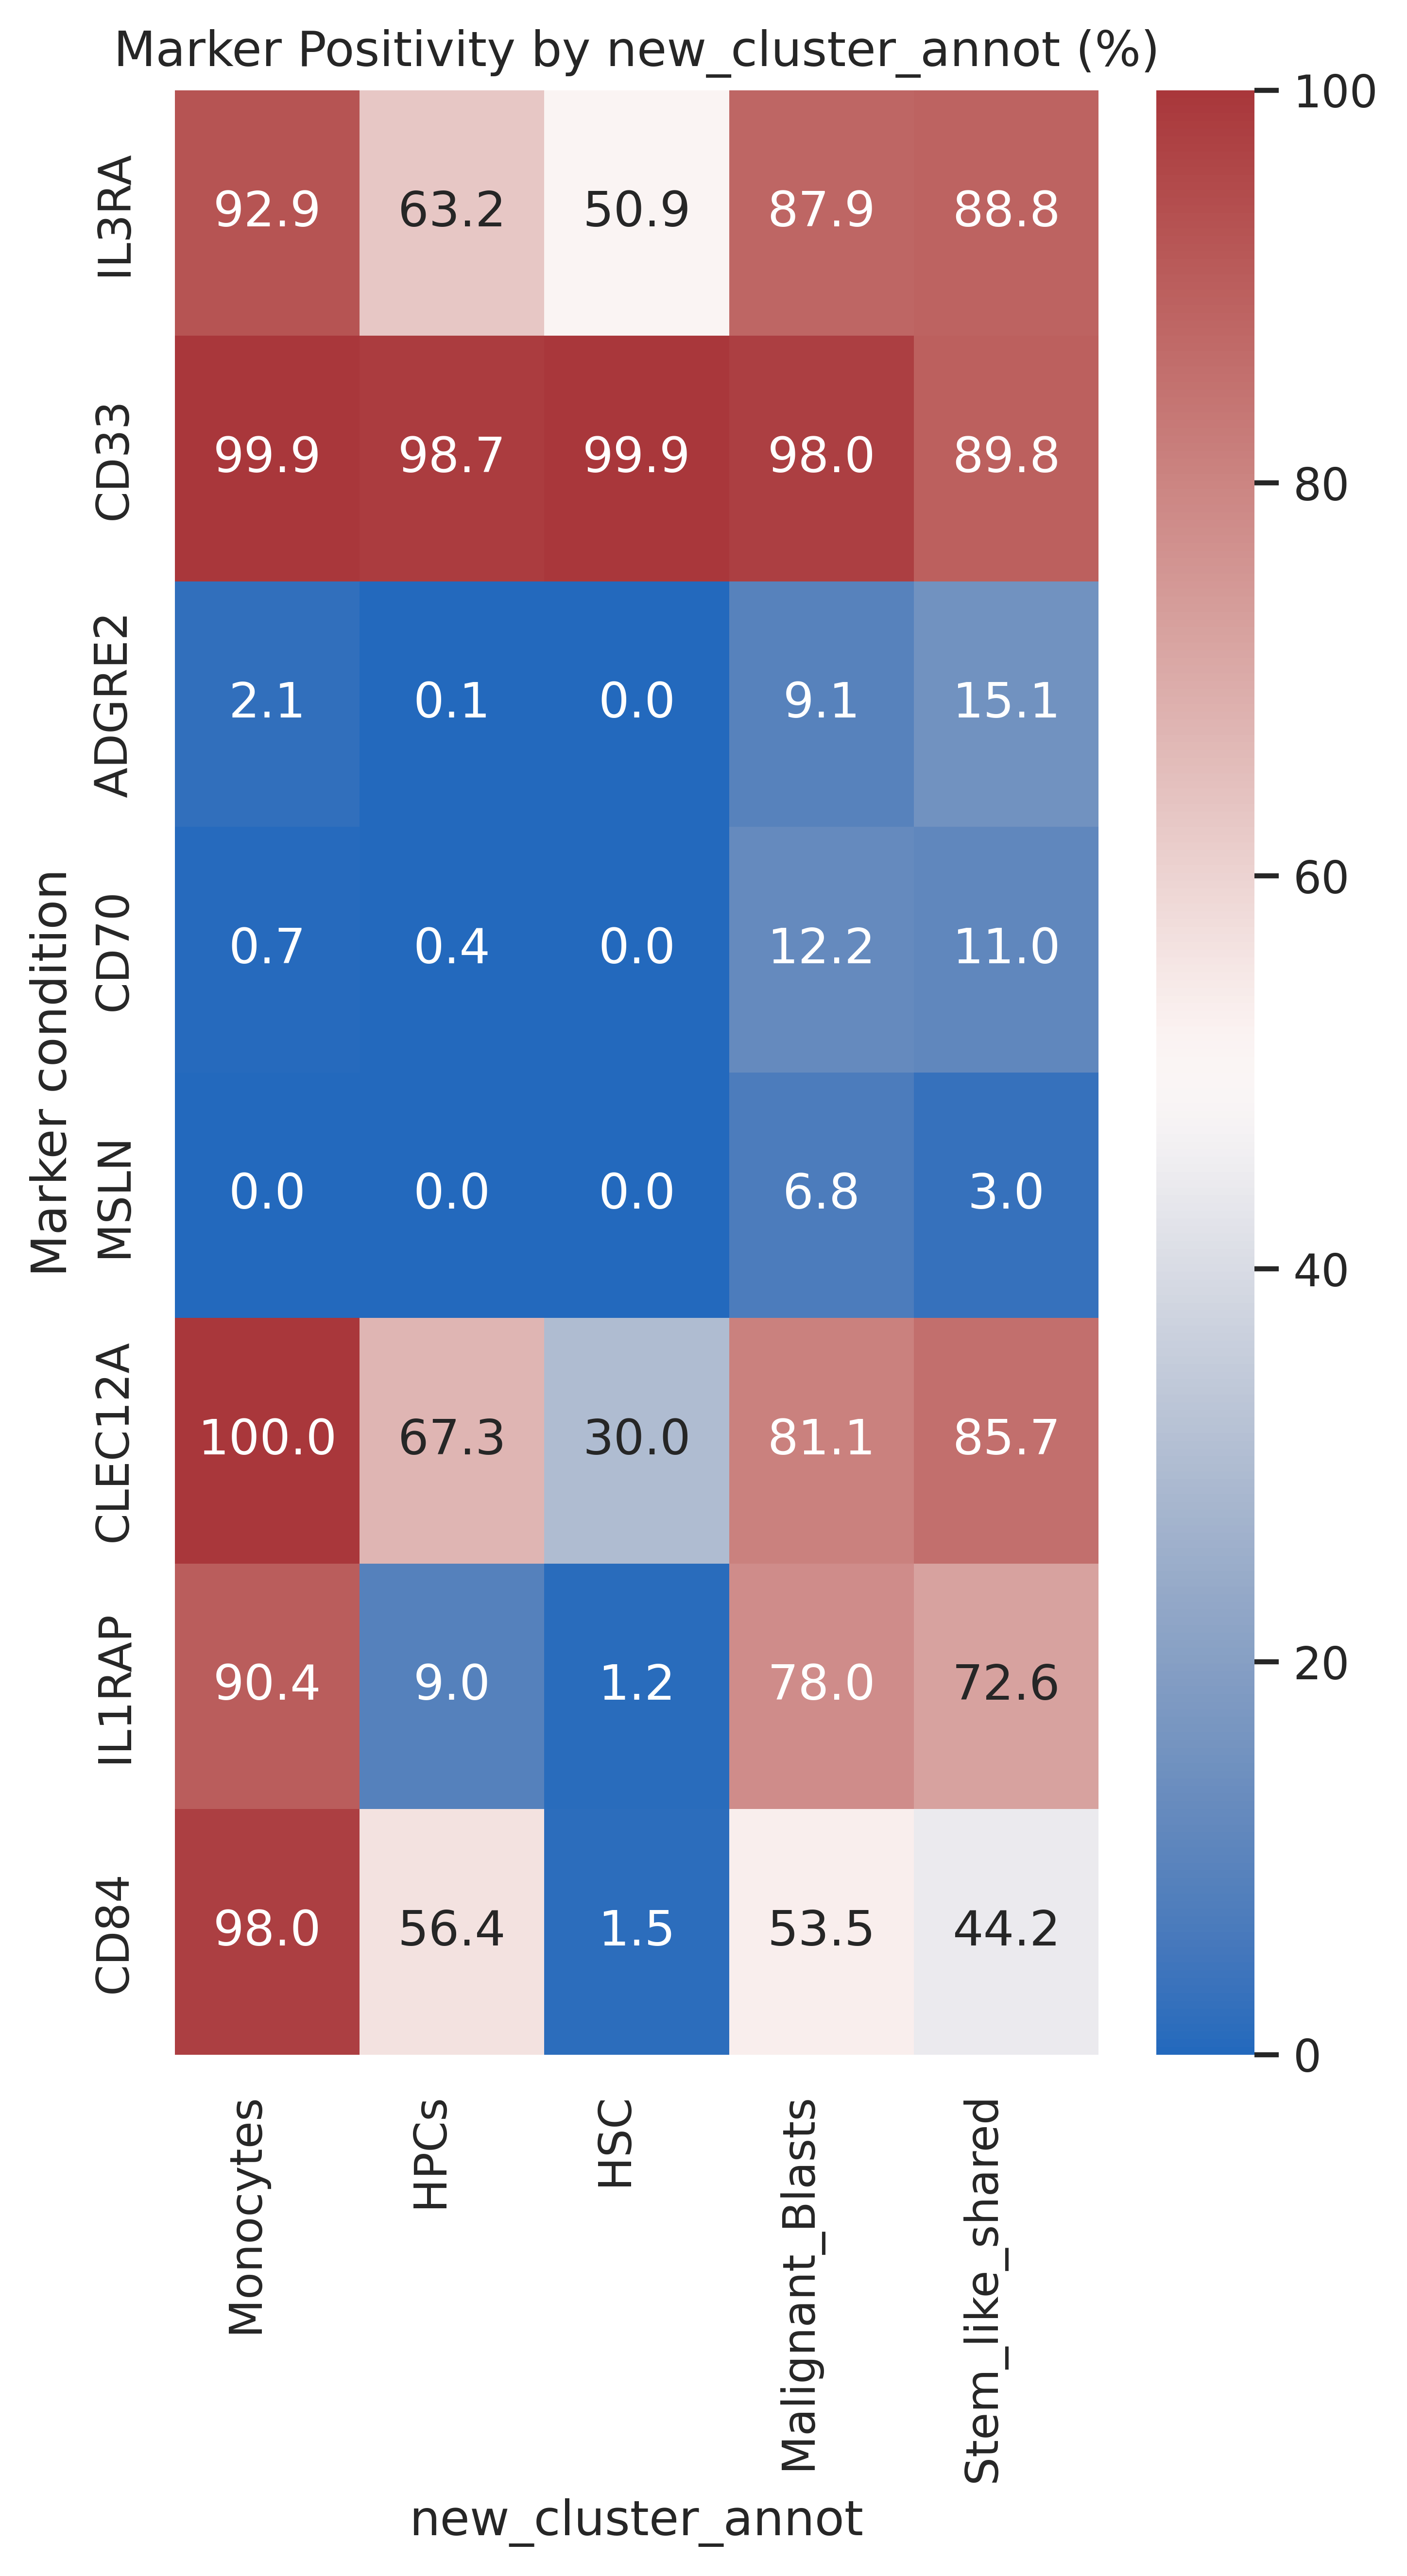

In [113]:
count_marker_combinations_heatmap(joint_obj_healthy_HSCs[~joint_obj_healthy_HSCs.obs["sample"].isin(["AML16_Rel"])], threshold = 1.1,
                                       gene_list = ["IL3RA","CD33","ADGRE2","CD70","MSLN","CLEC12A","IL1RAP","CD84"],
                                  layer = "scArch_transformed_log",
                           groupby =  "new_cluster_annot",show_combinations=False,swap_axes = True,
                                                                show_any_all=False,
                                  figsize = (5,9), normalize = True, cmap = "vlag", group_order = group_order,
                                 save_path = "/new_vs_old_targets.pdf")

In [91]:
AML_all["rna"].obs["new_cluster_annot"] = joint_obj_healthy_HSCs.obs["new_cluster_annot"]
AML_rna_sub = AML_all["rna"][:, ["IL3RA","CD33","ADGRE2","CD70","MSLN","CLEC12A","IL1RAP","CD84"]].copy()
group_order = ["Monocytes","HPCs", "HSC", "Malignant_Blasts", "Stem_like_shared"]

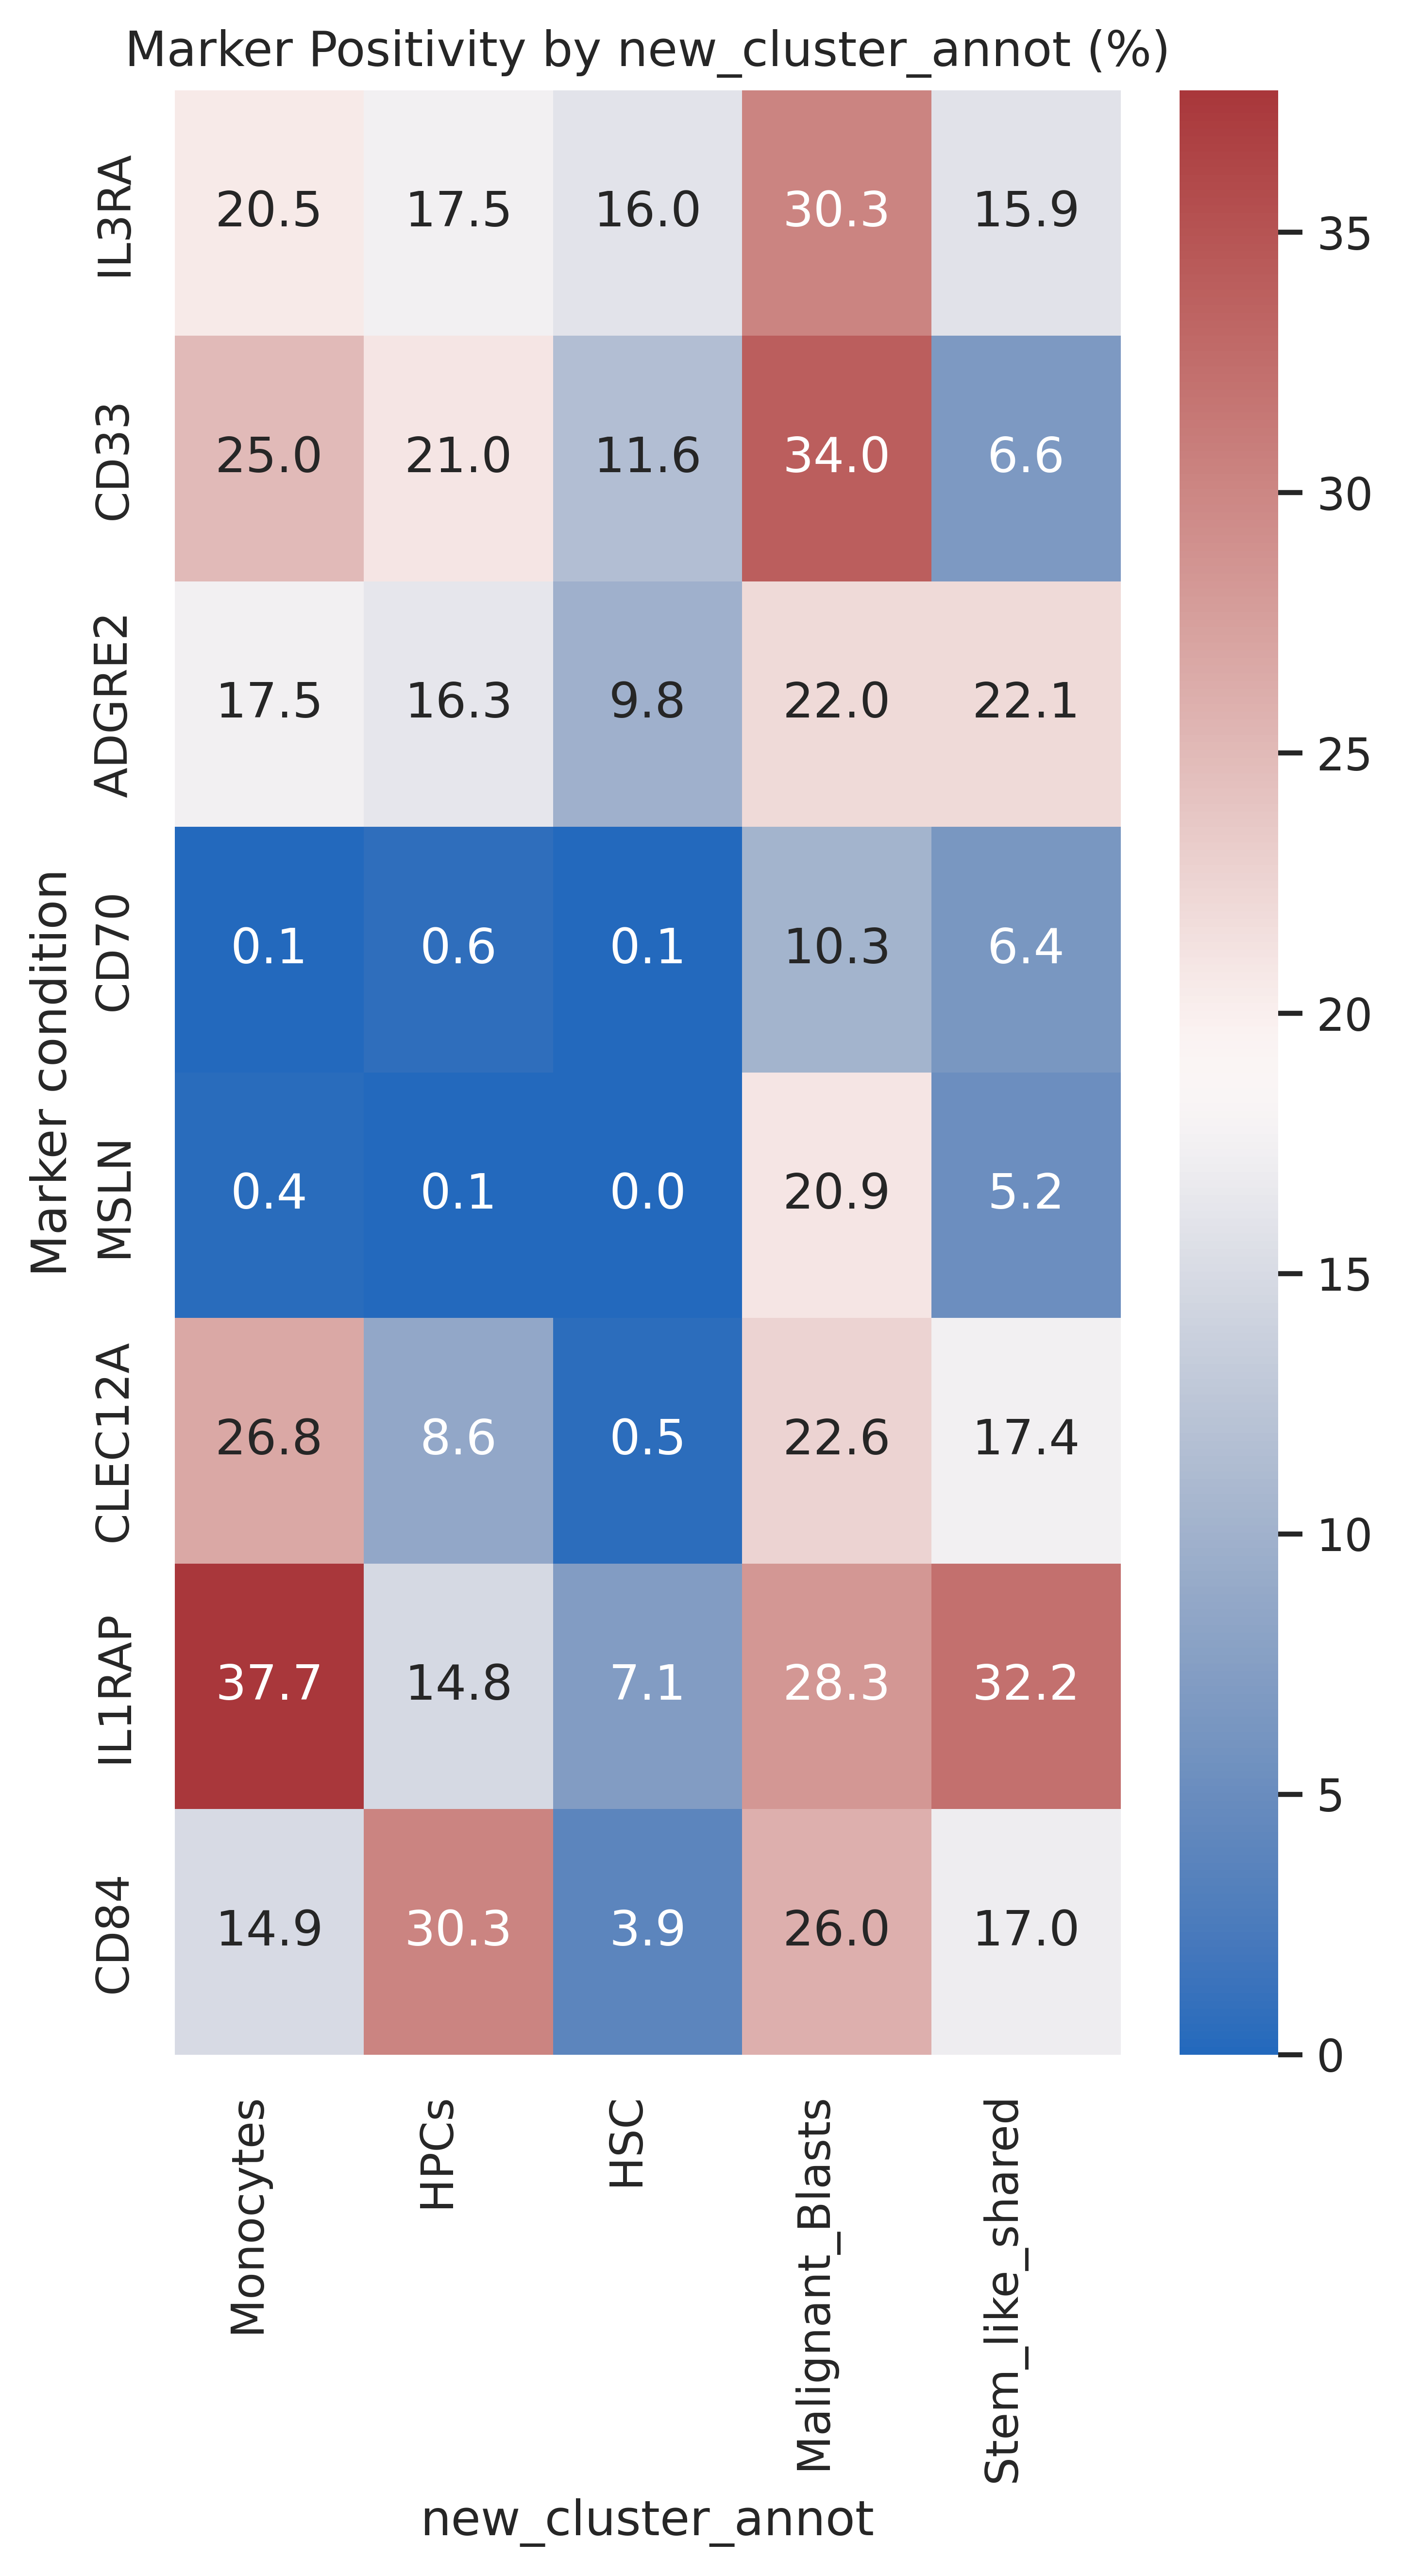

In [114]:
count_marker_combinations_heatmap(AML_rna_sub[~AML_rna_sub.obs["sample"].isin(["AML16_Rel"])], threshold = 0,
                                       gene_list = ["IL3RA","CD33","ADGRE2","CD70","MSLN","CLEC12A","IL1RAP","CD84"],
                                  layer = "raw_counts",
                           groupby =  "new_cluster_annot",show_combinations=False,swap_axes = True,
                                                                show_any_all=False,
                                  figsize = (5,9), normalize = True, cmap = "vlag", group_order = group_order,
                                   save_path = "/new_vs_old_targets_RNA_ECF.pdf")

In [115]:
group_order = ["DEK_NUP214","NUP98r", "RUNX1_RUNX1T1", "CBFB_MYH11","MNX1", "GLIS2","KMT2Ar"]

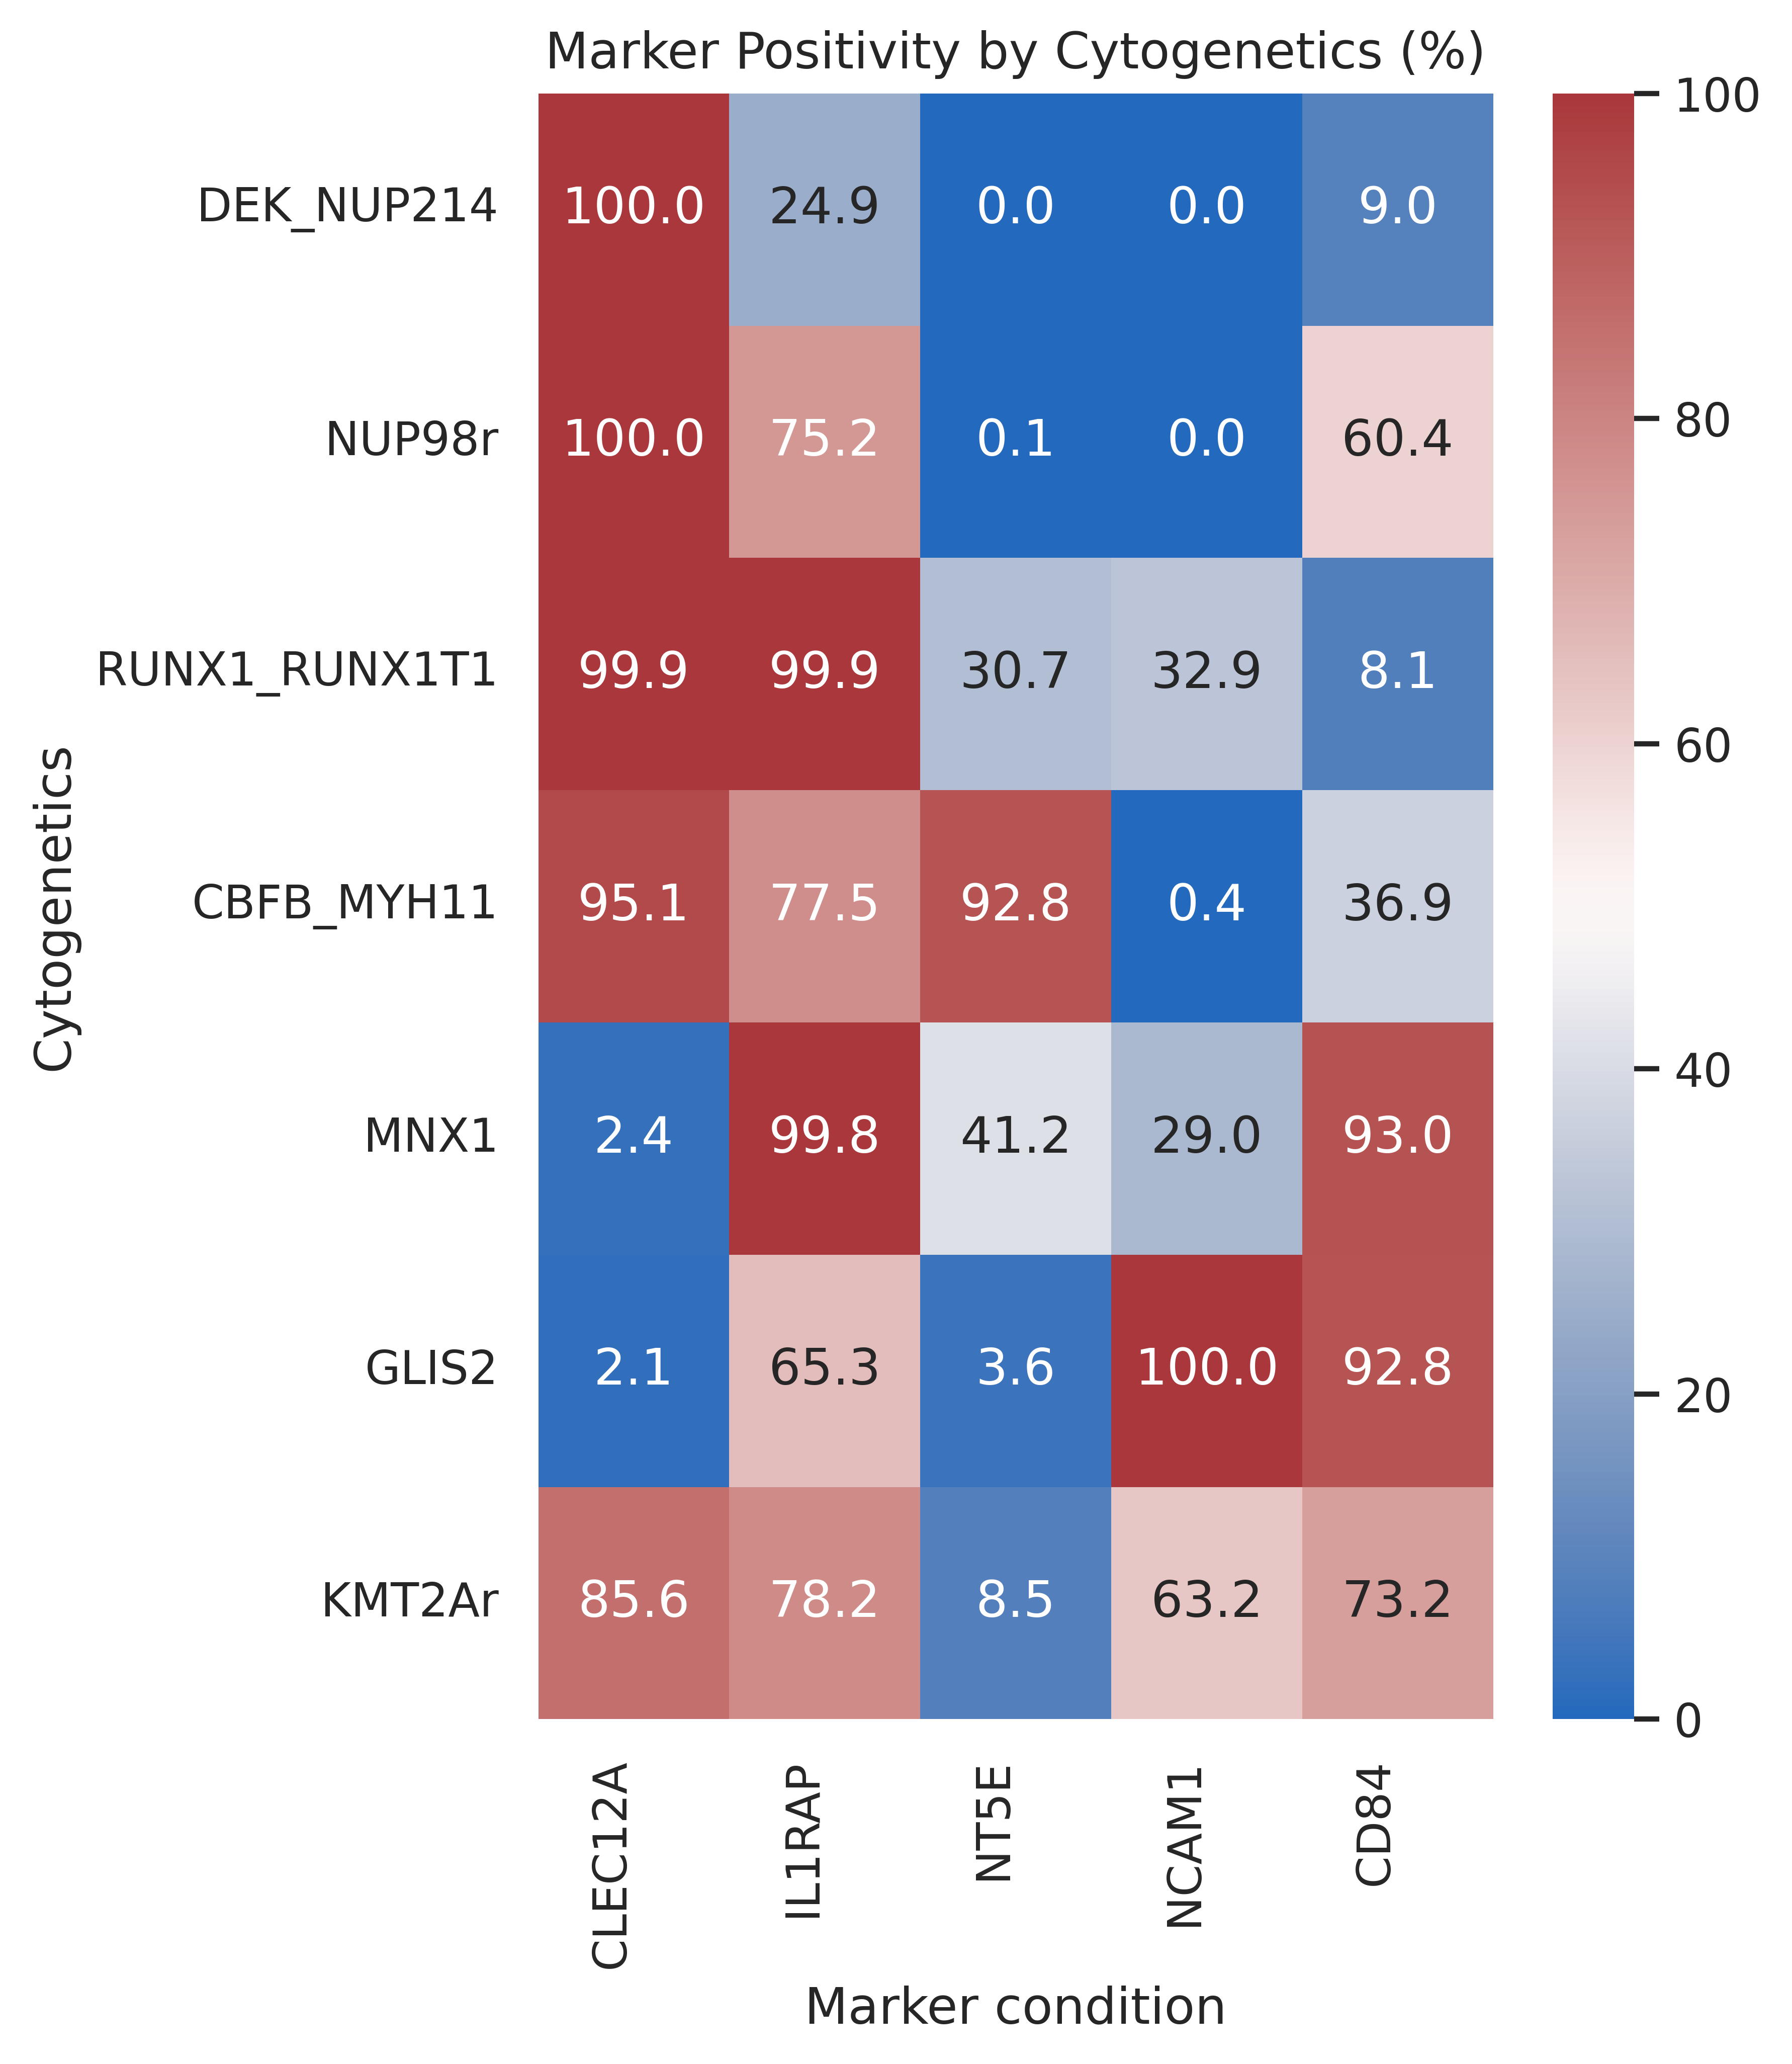

In [116]:
count_marker_combinations_heatmap(joint_obj_healthy_HSCs[(~joint_obj_healthy_HSCs.obs["sample"].isin(["AML16_Rel"])) &
                                                        (~joint_obj_healthy_HSCs.obs["Cytogenetics"].isin(["Healthy","unknown"]))], threshold = 1.1,
                                       gene_list = ["CLEC12A","IL1RAP","NT5E","NCAM1","CD84"],
                                  layer = "scArch_transformed_log",group_order = group_order,
                           groupby =  "Cytogenetics",show_combinations=False,swap_axes = False,
                                                                show_any_all=False,
                                  figsize = (6,7), normalize = True, cmap = "vlag", 
                                 save_path = "/targets_cyto.pdf")